<h1> University Hack 2022 </h1>
<h5> Equipo DataManda </h5>

<h2> Análisis exploratorio de los datos </h2>

Carga de las librerías necesarias

In [1]:
import pandas as pd
import plotly.express as px
import datetime as dt
import numpy as np
import geocoder
import matplotlib.pyplot as plt
import time
from tqdm import tqdm, trange
from tqdm.notebook import tqdm_notebook

<h3> Archivo "items_ordered_2_years.txt" </h3>

En primer lugar, abrimos el archivo para leer cuántas líneas tiene.

In [2]:
with open("./original_data/items_ordered_2years.txt", "r", encoding='utf8') as f:
    data = f.read().splitlines()
len(data)

930914

Este archivo dispone de 930914 líneas, una de ellas corresponde a los títulos de las columnas. Una vez conocido esto, pasamos a leerlo con pandas para convertirlo directamente a dataframe y trabajar más rápido.

In [3]:
items = pd.read_table('./original_data/items_ordered_2years.txt', sep ='|', engine='c', encoding='UTF-8', on_bad_lines='warn')
print('Registros: ', len(items))
items.head(2)

b'Skipping line 230152: expected 11 fields, saw 31\n'
b'Skipping line 876746: expected 11 fields, saw 21\n'


Registros:  930905


,num_order,item_id,created_at,product_id,qty_ordered,base_cost,price,discount_percent,customer_id,city,zipcode
0,562ba4ba9aaf2a1e926842deca19271d,2bca87c2ab10b07feef290a9be47f316,2017-01-01 00:20:33,6409,1,13.4204,17.17,8.0,50d7f99947b472cc889d58845b9d23e2,Valencia,46019
1,562ba4ba9aaf2a1e926842deca19271d,53e12ac4b579f0c4b1c4f77d50bf8792,2017-01-01 00:20:33,5133,1,18.5351,22.68,8.0,50d7f99947b472cc889d58845b9d23e2,Valencia,46019


Al leer el archivo con read_csv de pandas hemos pasado de 930914 a 930905 líneas, por lo que hemos perdido 9 registros; 2 de ellos nos avisa el propio pandas de que ha habido un error al leer la línea, pero los otros han "desaparecido".

Por ello, creo que lo más conveniente es realizar la conversión a dataframe "a mano", haciendo uso de los registros extraídos en primer lugar cuando hemos abierto el archivo. Cada línea se dividirá según el separador "|", y las que tengan un número de registros distinto de 11 se guardarán a parte para analizarlas, modificarlas según corresponda y añadirlas posteriormente.

In [4]:
data_splited = []
lines_wrong = []
pos_wrong = []
position = 0
for line in data:
    line_splited = line.replace('"', "").split("|")
    if len(line_splited) == 11:
        data_splited.append(line_splited)
    else:
        pos_wrong.append(position)
        lines_wrong.append(line_splited)
    position+=1

print('Lines splited: ', len(data_splited))
print('Lines wrong: ', len(lines_wrong))

items = pd.DataFrame(data_splited[1:], columns=data_splited[0])
items.head(2)

Lines splited:  930905
Lines wrong:  9


,num_order,item_id,created_at,product_id,qty_ordered,base_cost,price,discount_percent,customer_id,city,zipcode
0,562ba4ba9aaf2a1e926842deca19271d,2bca87c2ab10b07feef290a9be47f316,2017-01-01 00:20:33,6409,1,13.4204,17.17,8,50d7f99947b472cc889d58845b9d23e2,Valencia,46019
1,562ba4ba9aaf2a1e926842deca19271d,53e12ac4b579f0c4b1c4f77d50bf8792,2017-01-01 00:20:33,5133,1,18.5351,22.68,8,50d7f99947b472cc889d58845b9d23e2,Valencia,46019


Si analizamos los errores descubrimos lo siguiente:
<ol>
<li> Línea 143745: es una línea únicamente con "zipcode", que pertenece al de la línea anterior. Se lo añadimos al registro 143743. </li>
<li> Línea 230889: le faltan las dos últimas columnas, que encontramos en el registro siguiente (línea 230890). Juntamos ambas y se lo añadimos al dataframe.
<li> Línea 230891: mismo caso que el anterior, juntamos con la línea 230892. </li>
<li> Línea 670816: tiene un registro más porque el código postal es "4595-349Penamaior|Apartado33" y lo divide en "|". Cogemos los dos campos, los combinamos y dejamos la línea con 11 registros.
<li> Línea 670817: ídem.
<li> Línea 670818: ídem.
<li> Línea 670819: ídem.
</ol>

In [5]:
#1
items.loc[143743]['zipcode'] = lines_wrong[0][0]

#2
new_line_1 = lines_wrong[1][:-1]
new_line_1.extend(lines_wrong[2])

#3
new_line_2 = lines_wrong[3][:-1]
new_line_2.extend(lines_wrong[4])

#4
new_line_3 = lines_wrong[5][:-2]
new_line_3.extend([str(lines_wrong[5][-2] + "|" + lines_wrong[5][-1])])

#5
new_line_4 = lines_wrong[6][:-2]
new_line_4.extend([str(lines_wrong[6][-2] + "|" + lines_wrong[6][-1])])

#6
new_line_5 = lines_wrong[7][:-2]
new_line_5.extend([str(lines_wrong[7][-2] + "|" + lines_wrong[7][-1])])

#7
new_line_6 = lines_wrong[8][:-2]
new_line_6.extend([str(lines_wrong[8][-2] + "|" + lines_wrong[8][-1])])

Una vez corregido, añadimos todo al dataframe.

In [6]:
%%capture --no-display
lineas_añadir = [new_line_1, new_line_2, new_line_3, new_line_4, new_line_5, new_line_6]

for line in lineas_añadir:
    linea = pd.Series(dict(zip(items.columns, line)))
    items = items.append(linea, ignore_index=True)

items.tail()

,num_order,item_id,created_at,product_id,qty_ordered,base_cost,price,discount_percent,customer_id,city,zipcode
930905,02055035a780a23bac949c5874784433,7758fe366ada96dd9318e788d2f485e0,2017-09-26 19:41:34,7782,1,15.4511,28.23,15,dadcdf86fc3d7a1ed783a4eccd5350b9,Lorca,30800
930906,d1a0d0ffa09c7d0d54ea1e8979121439,3e4c14a99f7718fe1e18c4f5756387e8,2018-09-10 13:19:42,13341,1,8.29,9.71,5,bd64e4b23bd2aefb6921034a1cc76730,Paços de Ferreira,4595-349Penamaior|Apartado33
930907,d1a0d0ffa09c7d0d54ea1e8979121439,0ca4ed3574b0a179378398f342b51c83,2018-09-10 13:19:42,5539,1,9.34,11.21,5,bd64e4b23bd2aefb6921034a1cc76730,Paços de Ferreira,4595-349Penamaior|Apartado33
930908,d1a0d0ffa09c7d0d54ea1e8979121439,fa9000c1202f33db42421c1563001def,2018-09-10 13:19:42,3368,1,6.2,6.52,5,bd64e4b23bd2aefb6921034a1cc76730,Paços de Ferreira,4595-349Penamaior|Apartado33
930909,d1a0d0ffa09c7d0d54ea1e8979121439,6e1a507fc938e441c9936496d8a73a11,2018-09-10 13:19:42,3363,1,9.106,9.55,5,bd64e4b23bd2aefb6921034a1cc76730,Paços de Ferreira,4595-349Penamaior|Apartado33


Vemos como los registros han sido incluidos al final del dataframe y ya disponemos de todos los datos. Antes de proseguir con el análisis, convertimos cada columna al tipo deseado según la información proporcionada.

In [7]:
items['created_at'] = pd.to_datetime(items['created_at'])
items.base_cost.replace('NA', np.nan, inplace=True) # los NA estaban registrados como string
items.zipcode.replace("1370\\", "13700", inplace=True) # un código postal que casualmente he descubierto que estaba mal
items['city'] = items.city.str.capitalize()
items = items.astype({'qty_ordered': 'int', 'base_cost': 'float', 'price': 'float', 'discount_percent': 'float'})
items.dtypes

num_order                   object
item_id                     object
created_at          datetime64[ns]
product_id                  object
qty_ordered                  int32
base_cost                  float64
price                      float64
discount_percent           float64
customer_id                 object
city                        object
zipcode                     object
dtype: object

Podemos observar los principales estadísticos de las columnas numéricas.

In [8]:
items.describe()

,qty_ordered,base_cost,price,discount_percent
count,930910.000000,928508.000000,930910.000000,930910.000000
mean,1.354651,8.497943,10.883488,8.188978
std,1.280744,77.508452,9.888204,6.760161
min,1.000000,-164.797400,0.000000,1.000000
25%,1.000000,3.304675,4.690000,5.000000
50%,1.000000,6.095400,8.220000,6.000000
75%,1.000000,10.465000,13.960000,10.000000
max,120.000000,47251.000000,650.830000,100.000000


Lo que más destaca son los datos de "base_cost" en los que tenemos NA, valores negativos y valores muy altos. El máximo es de 47k, lo cual es imposible porque el precio máximo es de 650 y el coste base debe ser menor que éste. Habrá que analizar esta columna y ver qué ocurre con esos valores extremos (positivos y negativos). 

En las demás no se ve nada extraño. La cantidad media pedida de cada producto es de 1.35 y el máximo es de 120, lo cual puede resultar también raro y habría que analizar. 
El precio medio de los productos pedidos estos dos años es de 10.88 euros, y el descuento medio aplicado es del 8.18%.

In [9]:
print('base_cost > price:', len(items[(items.base_cost > items.price)]) )
print('base_cost > 1000:', len(items[(items.base_cost > items.price) & (items.base_cost > 11)]))
print('base_cost < 0:', len(items[(items.base_cost < 0)]))

base_cost > price: 10729
base_cost > 1000: 3612
base_cost < 0: 46


Dado que hay más de 10000 transacciones cuyo precio base es mayor que el precio de venta y más de 3000 de estas que se encuentran por encima del tercer cuartil, creo que lo más conveniente es igualar el precio base al precio de venta en estos casos. Con esto, nos quitaríamos los datos extremos positivos. También se van a tratar los datos negativos de los precios base igualándolos al precio de venta.

In [10]:
items.loc[(items.base_cost > items.price) | (items.base_cost < 0), 'base_cost'] = 0

En cuanto a las variables categóricas, nos encontramos lo siguiente.

In [11]:
print('Número de pedidos realizados:', len(items.num_order.unique()))
print('Número de clientes:', len(items.customer_id.unique()))
print('Número de ciudades:', len(items.city.unique()))

Número de pedidos realizados: 278043
Número de clientes: 118798
Número de ciudades: 13863


Agrupamos por fecha para sacar los datos relativos al número de unidades vendidas (orders) y la cantidad en euros (sales). Esto será lo que representemos en la página web.

In [12]:
items['date'] = items['created_at'].dt.date
items['eur_ordered'] = items.qty_ordered * items.price
items_select = items.groupby(['date']).agg(Sales = ('eur_ordered', np.sum), Orders = ('num_order', lambda x: x.nunique()))
items_select = items_select.asfreq('24h')
items_select = items_select.sort_index()
items_select = items_select.fillna(0)

print((items_select.index == pd.date_range(start=items_select.index.min(),
                                     end=items_select.index.max(),
                                     freq=items_select.index.freq)).all())

items_select.to_csv('./modified_data/sales_and_orders.csv', index=True)
pd.read_csv('./modified_data/sales_and_orders.csv').head().set_index('date')

True


,Sales,Orders
date,,
2017-01-01,29315.95,506.0
2017-01-02,9586.79,183.0
2017-01-03,766.50,31.0
2017-01-04,799.66,34.0
2017-01-05,2056.66,38.0


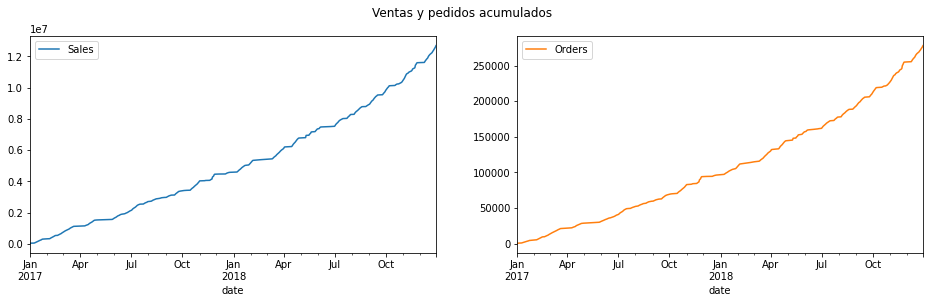

In [13]:
items_select.cumsum(axis=0).plot(subplots=True, layout=(1,2), figsize=(16,4))
plt.suptitle('Ventas y pedidos acumulados')
plt.show()

Con este conjunto de datos también podemos hacer uso de las ciudades y el código postal para analizar de dónde provienen los pedidos. Para ello, busco las coordenadas de las ciudades haciendo uso de *geocoder* y creo un dataframe con todas las longitudes y latitudes. Estos datos los podemos representar en un mapa y ver de forma interactiva desde dónde se realizan los pedidos.

In [14]:
# cities_coords = []
# not_found = []
# cities = items.city.str.capitalize().unique()
# print('Coordenadas de', len(cities), 'ciudades')
# with tqdm_notebook(total = 100, desc = 'Progress bar') as progressbar:
#     for city in cities:
#         coord = geocoder.osm(city).latlng
#         if not coord:
#             not_found.append(city)
#             continue
#         row = {'city': city, 'lat':coord[0], 'lon':coord[1]}
#         cities_coords.append(row)
#         time.sleep(0.9)

#         progressbar.update(100/len(cities))

# df_cities = pd.DataFrame.from_dict(cities_coords)
# df_cities.to_csv('./modified_data/coords_cities.csv', index=False)
df_cities = pd.read_csv('./modified_data/coords_cities.csv')
df_cities.head()

,city,lat,lon
0,Valencia,39.469707,-0.376335
1,Almeria,36.841420,-2.462814
2,Terrassa,41.562962,2.010049
3,Madrid,40.416705,-3.703582
4,Esplugues de llobregat,41.377680,2.089972


Uno los datos de longitudes y latitudes al dataframe original.

In [15]:
df_map = items[['city', 'item_id']].set_index('city')\
    .join(df_cities.set_index('city'), how='inner').reset_index()

df_map.to_csv('./modified_data/map.csv', index=False)
pd.read_csv('./modified_data/map.csv').head()

,city,item_id,lat,lon
0,castellon de la plana,c65e63a81ea73f5b2dd0ff1375499477,39.986035,-0.037735
1,08911,d274d373b0dc62c6a44928ca46958248,41.453541,2.253445
2,aldaia,ea7f70fab35a0eb7e84fab75b1ac5473,39.464789,-0.460760
3,aldaia,1ea44fa2b4f690a4f3b73c7dd5bc4774,39.464789,-0.460760
4,aldaia,6b7d9ddf459574cafc680d2d6483e8b6,39.464789,-0.460760


También podemos agrupar por longitud y latitud y contar los valores, de manera que se hace más fácil la representación en mapa.

In [16]:
df_coords = df_cities.groupby(['lat', 'lon']).size().reset_index(name='counts')
df_coords.to_csv('./modified_data/coords.csv', index=False)
pd.read_csv('./modified_data/coords.csv').head()

,lat,lon,counts
0,-53.149225,-70.932561,1
1,-47.752852,-65.898249,1
2,-45.871288,-67.494256,2
3,-45.397505,170.177892,1
4,-42.771017,-65.054346,1


In [17]:
px.scatter_geo(df_coords, lat=df_coords.lat, lon=df_coords.lon, size='counts', scope='europe')

Las ciudades desde donde más se compra son las siguientes:

In [18]:
df_map.groupby(['city']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

,city,counts
6888,Madrid,99774
1644,Barcelona,41216
11994,Valencia,19165
10935,Sevilla,13476
2089,Bilbao,8887
12042,Valladolid,6517
822,Alicante,5703
424,Albacete,5637
6889,Madrid,5518
6984,Malaga,5267


<h3> Archivo "products_categories.csv" </h3>

Leemos el archivo con pandas, como hemos hecho en el caso anterior, para echarle un primer vistazo.

In [19]:
products_cat = pd.read_csv('./original_data/products_categories.csv', encoding='latin1', on_bad_lines='warn', engine='c')
products_cat[products_cat.isnull().any(1)].tail()

b'Skipping line 8449: expected 4 fields, saw 5\n'


,sku,cat1,cat2,cat3
10894,"WJW158100,Salud,""Huesos, articulaciones y músc...",NaN,NaN,NaN
10914,"WJW201100,Salud,""Huesos, articulaciones y músc...",NaN,NaN,NaN
10921,"WJW236101,Nutrición,Alimentos,""Cremas, salsas ...",NaN,NaN,NaN
10956,"ZAM01-15664,Salud,""Huesos, articulaciones y mú...",NaN,NaN,NaN
11081,"ZMCOLMAV,Salud,""Huesos, articulaciones y múscu...",NaN,NaN,NaN


En este caso hay líneas que se leen incorrectamente porque contienen una categoría que está escrita con comas y, al ser un archivo csv, se realiza la separación por esas comas y sale una categoría más.

Seguimos la misma estrategia que con el primer archivo y leemos el archivo línea a línea para posteriormente crear una estrategia de división.

In [20]:
with open('./original_data/products_categories.csv', "r", encoding='latin1') as f:
    data_cat = f.read().splitlines()
len(data_cat)

11160

Después de una ligera investigación, como lo que ocurre es que "cat2" es el dato incorrecto que se divide en dos, creo una función que separe por comas y junte esos dos campos que no deberían haberse separado. De esta forma, obtengo una línea dividida en 4 campos.

In [21]:
def linea_de_5(line):
    line = line.replace('"', '').split(',')
    line = [line[0], line[1], line[2]+line[3], line[4]]
    return line

In [22]:
new_data_splitted = []
longs_mal = []
for linea in data_cat:
    new_line = linea.split(',')
    if len(new_line) == 4:
        new_data_splitted.append(new_line)
    elif len(new_line) == 5:
        new_line = linea_de_5(linea)
        new_data_splitted.append(new_line)

products_cat = pd.DataFrame(new_data_splitted[1:], columns=new_data_splitted[0])
print(len(products_cat))
print(len(products_cat[products_cat.isnull().any(1)]))
products_cat.to_csv('./modified_data/categories_bien.csv', index=False)
products_cat.head()

11159
0


,sku,cat1,cat2,cat3
0,00.01.10.014,Cosmética y Belleza,Corporal,Hidratación
1,00.071697.000.000,Infantil,Juguetes,Mordedores
2,000133,Infantil,Higiene infantil,Canastillas y kits bebé
3,000147,Higiene y cuidado personal,Facial,Desmaquillantes y limpiadores
4,000148,Cosmética y Belleza,Manos,Crema de Manos


Vemos como ahora no hay ningún registro que se haya guardado incorrectamente.

<h3> Archivo "products.csv" </h3>

Leemos el archivo. Esta vez no nos da ningún error.

In [23]:
products = pd.read_csv('./original_data/products.csv', on_bad_lines='warn')
products.head()

,product_id,sku,name,marca_value,short_description,analytic_category,picture
0,7349,165774,Pañales CHELINO LOVE Talla3 4-10 KG 36unidades,Chelino,"<p>Los pañales <strong>Chelino</strong>, que p...",Infantil,https://www.mifarma.es/media/catalog/product/1...
1,7347,165776,Pañales CHELINO LOVE Talla5 13-18 KG 30unidades,Chelino,<p>Los pañales Chelino que presentan un novedo...,Infantil,https://www.mifarma.es/media/catalog/product/1...
2,50282,230154,Pañales Pingo Maxi T4 40 uds,Pingo,<p>Pingo es el primer pañal ecológico con cuat...,Infantil,https://www.mifarma.es/media/catalog/product/2...
3,7348,165775,Pañales CHELINO LOVE Talla4 9-15 KG 34unidades,Chelino,"<p>Los pañales Chelino, que presentan un noved...",Infantil,https://www.mifarma.es/media/catalog/product/1...
4,24517,011905,Dodot Pañal T4 9-15Kg 30unds,Dodot,<p>¿Qué le pides a un pañal? ¿Absorción máxima...,NaN,https://www.mifarma.es/media/catalog/product/0...


<p> Comprobamos que el tipo de cada columna coincide con el esperado </p>

In [24]:
products.dtypes

product_id            int64
sku                  object
name                 object
marca_value          object
short_description    object
analytic_category    object
picture              object
dtype: object

<p> Manejando los datos, observamos que hay filas repetidas con pequeñas variaciones. Se mantiene el mismo 'sku', pero hay variaciones en otros campos como la descripción </p>

In [25]:
products.groupby('sku').agg(count = ('sku', 'count')).sort_values('count', ascending=False).head()

,count
sku,
178667,4
167128,4
CHCOMMAT,4
150113,4
159078,4


<p> Si hacemos el mismo análisis pero con 'product_id', observamos que hay valores repetidos también, pero al analizarlos vemos que tienen distinto 'sku'. Esto se debe a que puede ser, por ejemplo, el mismo producto pero de distinta talla </p>

In [26]:
products.groupby('product_id').agg(count = ('product_id', 'count')).sort_values('count', ascending=False).head()

,count
product_id,
2492,4
1792,4
21686,4
13102,4
7657,4


<p> Por ello, eliminamos las filas que repitan tanto 'sku' como 'product_id' </p>

In [27]:
products = products.drop_duplicates(subset = ['sku', 'product_id'])

Para realizar el análisis de este dataset, lo juntamos con 'items_ordered_2_years' para obtener la información del número de pedidos, y con 'products_categories' para obtener las categorías a las que pertenece cada uno. De esta manera podremos obtener información de los productos más vendidos con sus categorías.

In [28]:
items_grouped = items.groupby(['product_id']).agg(Sales = ('eur_ordered', np.sum), Orders = ('num_order', lambda x: x.nunique()))
items_grouped.index = items_grouped.index.astype('int')
products_with_cats = products[['product_id', 'sku', 'name']].set_index('sku').join(products_cat.set_index('sku'), on='sku').set_index('product_id')
items_categories = items_grouped.join(products_with_cats).sort_values('Sales', ascending=False).reset_index()

items_categories.to_csv('./modified_data/items_categories.csv', index=False)
pd.read_csv('./modified_data/items_categories.csv').head()

,product_id,Sales,Orders,name,cat1,cat2,cat3
0,36673,56735.98,928,Carticure Plus 30 Stick,Salud,Huesos articulaciones y músculos,Colágeno
1,5036,53046.18,2091,Sesderma C-Vit Liposomal Serum 30 ml,Cosmética y Belleza,Facial,Antiarrugas
2,7348,50149.93,2505,Pañales CHELINO LOVE Talla4 9-15 KG 34unidades,Infantil,Cambio de pañal,Pañales
3,7349,43939.06,2692,Pañales CHELINO LOVE Talla3 4-10 KG 36unidades,Infantil,Cambio de pañal,Pañales
4,2789,39277.60,1233,Martiderm Proteoglicanos Fps 30 Ampollas,Cosmética y Belleza,Facial,Ampollas


In [29]:
%%capture --no-display
px.sunburst(items_categories.dropna(), path=['cat1', 'cat2'])

La categoría más vendida es cosmética y belleza, seguida de higiene y cuidado personal. 